# Load Preprocessed Data

In [ ]:
# importing Libraries
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Suppress warnings to keep the output cleaner.
warnings.filterwarnings('ignore')

df = pd.read_csv("/content/weekly_sales.csv")   # Load the dataset
df = df.drop(columns=["Unnamed: 0"])        # Drop the unnecessary index column
df["date"] = pd.to_datetime(df["date"])     # Convert date to datetime format

df.head()   # Display the first few rows of the dataset

,pizza_name_id,week_number,quantity,holiday,date
0,bbq_ckn_l,1,12,False,2015-01-01
1,bbq_ckn_l,2,25,False,2015-01-08
2,bbq_ckn_l,3,24,False,2015-01-15
3,bbq_ckn_l,4,15,False,2015-01-22
4,bbq_ckn_l,5,27,True,2015-01-29


# Checking Stationarity

The Augmented Dickey-Fuller (ADF) test is a statistical test that determines if a time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(df['quantity'])

# adfuller returns a tuple of values. Let's unpack them:
adf_statistic, p_value, used_lag, n_obs, x, y = adf_result

# Display the results
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Used lag:", used_lag)
print("Number of observations used:", n_obs)

ADF Statistic: -7.257875725687084
p-value: 1.7118758679379692e-10
Used lag: 32
Number of observations used: 4721


**Here's the breakdown:**

- ADF Statistic: -7.2579
This value is significantly more negative than the typical critical values (often around -3.5 for a 5% significance level), which indicates strong evidence against the presence of a unit root.

- p-value: 1.7119e-10
The p-value is extremely low (far below any common significance level such as 0.05), reinforcing the decision to reject the null hypothesis.

- Used lag: 32
This indicates that the test used 32 lagged difference terms to account for serial correlation.

- Number of observations used: 4721
A large sample size, which provides a reliable test outcome.

**Conclusion:**

The time series is stationary. This means that its statistical properties (mean, variance, autocorrelation, etc.) do not change over time. In practical terms, this stationarity is favorable for many time series modeling techniques, such as ARIMA, because it implies that the data is stable over time and past values are predictive of future values.

# Model Building & Selection

## MAPE (Mean Absolute Percentage Error)

Define a function to calculate the Mean Absolute Percentage Error (MAPE)

In [ ]:
def mean_absolute_percentage_err(actual, predicted):
    return float(round(np.mean(np.abs((actual - predicted) / actual)) * 100, 2))

# Store all MAPE score by using this dictionary
mape_scores = {}

## ARIMA MODEL

StatsForecast is a modern forecasting library that includes an AutoARIMA implementation (similar to pmdarima but often faster).

**Pros:**
- Very fast in production (written in Rust under the hood).
- Clean API for multiple time series at once.
- Supports advanced models beyond ARIMA (e.g., ETS, Prophet, Neural forecasts, etc.).

**Cons:**
- Requires learning a slightly different “tidy” data format ([unique_id, ds, y]).

In [4]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Aggregate quantity sold per week (across all pizza types)
arima_df = df.copy()
arima_df = arima_df.groupby("week_number")["quantity"].sum().reset_index()

# Train-test split (80% train, 20% test)
train_size = int(len(arima_df) * 0.8)
train, test = arima_df.iloc[:train_size], arima_df.iloc[train_size:]

# Define p, d, q values to try
p_values = range(0, 4)  # AR terms
d_values = range(0, 3)  # Differencing
q_values = range(0, 4)  # MA terms

# Find the best ARIMA model based on AIC
best_aic = np.inf
best_order = None
best_model = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train["quantity"], order=(p, d, q))
        model_fit = model.fit(start_params=[0.1, 0.1, 0.1])
        aic = model_fit.aic  # Get AIC score

        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_model = model_fit
    except:
        continue  # Skip invalid combinations

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

# Forecast using the best model
forecast = best_model.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Evaluate performance
mape = mean_absolute_percentage_err(test["quantity"], forecast)
print(f"Mean Absolute Percentage Error: {mape}%")
mape_scores["ARIMA"] = mape

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best ARIMA order: (0, 2, 2) with AIC: 494.65337502505656
Mean Absolute Percentage Error: 18.32%


**Visualizing the model**
- Seaborn Theme: Using sns.set_theme(style="whitegrid") provides a cleaner grid and overall appearance.

- Markers & Line Styles: Customized markers ('o' for actual data, 'x' for forecasts) and line widths make the plot more distinguishable.

- Font and Layout Enhancements: Larger font sizes for titles, axis labels, and legends increase readability. plt.tight_layout() ensures everything fits well within the figure boundaries.

- Custom Grid: Adjusted grid style for better visual separation without overwhelming the plot.

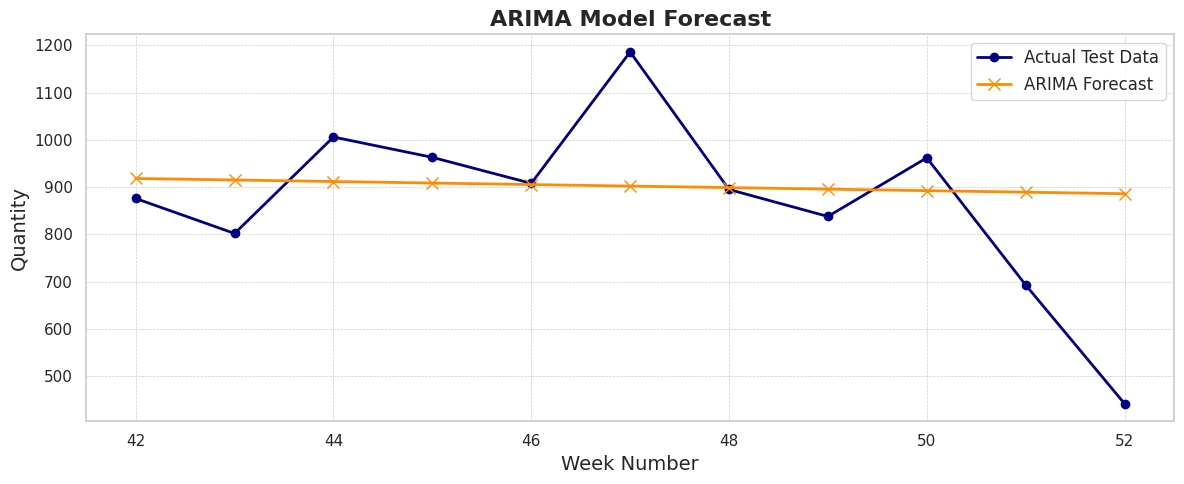

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a seaborn theme for a more refined style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 5))

# Plot actual test data with markers and a thicker line
plt.plot(test.index, test["quantity"],
         marker='o', markersize=6, linewidth=2,
         color='navy', label='Actual Test Data')

# Plot forecasted data with different markers and color for differentiation
plt.plot(test.index, forecast,
         marker='x', markersize=8, linewidth=2,
         color='darkorange', label='ARIMA Forecast')

# Labeling the axes and title with increased font sizes
plt.xlabel('Week Number', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.title('ARIMA Model Forecast', fontsize=16, fontweight='bold')

# Display legend with a larger font and a grid with custom styling
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## SARIMA MODEL

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data Preparation
sarima_df = df.copy()
sarima_df = sarima_df.groupby("week_number")["quantity"].sum().reset_index()

# Train-Test Split (80/20 split)
train_size = int(len(sarima_df) * 0.8)
train = sarima_df.iloc[:train_size]
test = sarima_df.iloc[train_size:]

# Define SARIMA Model Parameters
'''order: (p, d, q) for non-seasonal components.
seasonal_order: (P, D, Q, s) for seasonal components, where s is the seasonal period.'''
order = (0, 2, 2)
seasonal_order = (1, 1, 1, 12)

# Model Fitting
model = SARIMAX(train["quantity"],
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=False)

# Using get_forecast for out-of-sample prediction
forecast = model_fit.get_forecast(steps=len(test)).predicted_mean
forecast.index = test.index

# Evaluate performance
mape = mean_absolute_percentage_err(test["quantity"], forecast)
print(f"Mean Absolute Percentage Error: {mape}%")
mape_scores["SARIMA"] = mape

Mean Absolute Percentage Error: 22.15%


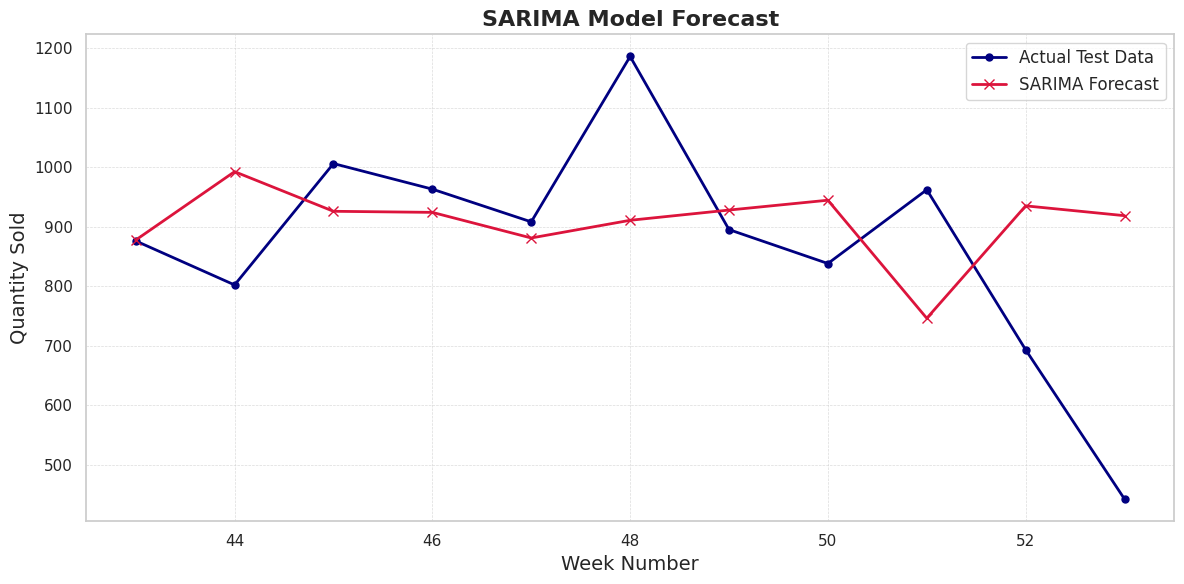

In [7]:
# Visualization
# -----------------------------
plt.figure(figsize=(12, 6))
plt.plot(test["week_number"], test["quantity"],
         marker='o', markersize=5, linewidth=2, label='Actual Test Data', color='navy')
plt.plot(test["week_number"], forecast,
         marker='x', markersize=7, linewidth=2, label='SARIMA Forecast', color='crimson')

# Customizing the plot for a polished appearance
plt.xlabel('Week Number', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)
plt.title('SARIMA Model Forecast', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

## Prophet Model

In [8]:
!pip install prophet

In [9]:
from prophet import Prophet

# Data Preparation
prophet_df = df.groupby("date")["quantity"].sum().reset_index()

# Train-Test Split (80/20)
train_size = int(len(prophet_df) * 0.8)
train, test = prophet_df.iloc[:train_size], prophet_df.iloc[train_size:]

# Rename columns to match Prophet's expected format
train = train.rename(columns={"date": "ds", "quantity": "y"})
test = test.rename(columns={"date": "ds", "quantity": "y"})

# Prophet Model Initialization and Training
model = Prophet(weekly_seasonality=True)
model.fit(train)

# Using test set dates for forecasting
future = test[['ds']].copy()
forecast = model.predict(future)

# Preparing Forecast for Plotting
forecast.set_index('ds', inplace=True)
test.set_index('ds', inplace=True)

# Extract predictions (Prophet's default forecast column is 'yhat')
predictions = forecast['yhat'].reindex(test.index)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4dnxgdiw/hovl2jzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4dnxgdiw/_da5uwfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=956', 'data', 'file=/tmp/tmp4dnxgdiw/hovl2jzz.json', 'init=/tmp/tmp4dnxgdiw/_da5uwfc.json', 'output', 'file=/tmp/tmp4dnxgdiw/prophet_modelpjmi9z9s/prophet_model-20250412031542.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:15:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:15:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [10]:
# Evaluate performance
mape = mean_absolute_percentage_err(test["y"], predictions)
print(f"Mean Absolute Percentage Error: {mape}%")
mape_scores["Prophet"] = mape

Mean Absolute Percentage Error: 21.33%


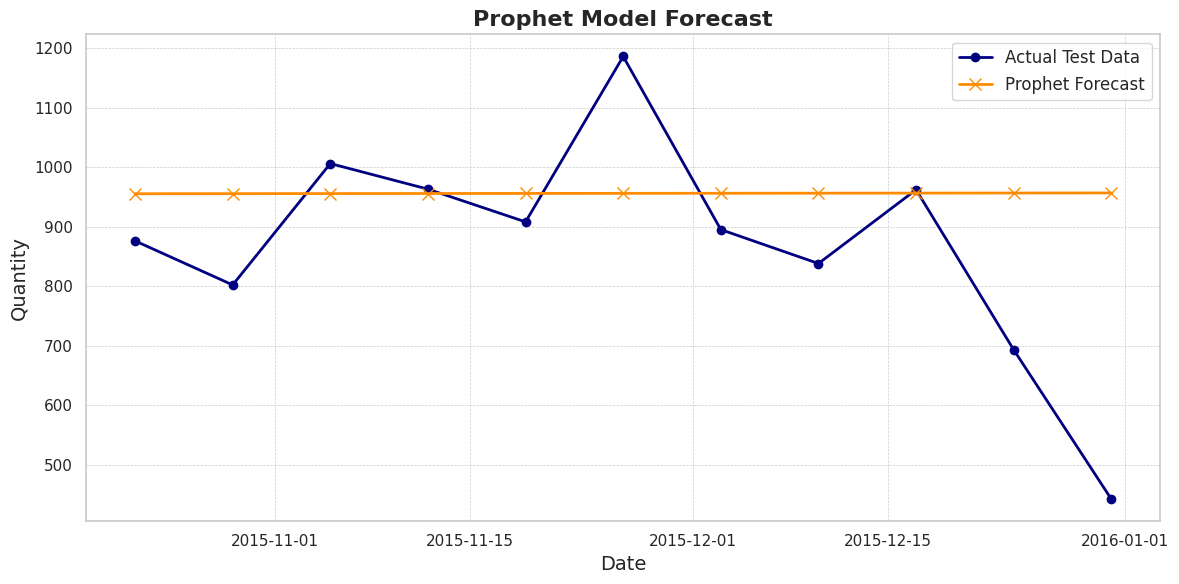

In [11]:
# Enhanced Plotting of Results
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot actual test data
plt.plot(test.index, test["y"],
         marker='o', markersize=6, linewidth=2,
         color='navy', label='Actual Test Data')

# Plot Prophet forecast data
plt.plot(test.index, predictions,
         marker='x', markersize=8, linewidth=2,
         color='darkorange', label='Prophet Forecast')

# Setting plot labels and title
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity', fontsize=14)
plt.title('Prophet Model Forecast', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## LSTM Model

In [12]:
!pip install tensorflow

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. Data Preparation
lstm_df = df.groupby("date").agg({
    'quantity': 'sum',
    'week_number': 'first',
    'holiday': 'any'
}).reset_index()

# Scale only the 'quantity' column
scaler = MinMaxScaler(feature_range=(0, 1))
quantity_scaled = scaler.fit_transform(lstm_df[['quantity']])  # 2D input required

# 2. Create Input Sequences for LSTM
def create_sequences(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

# Set the number of time steps (look-back period)
time_steps = 3
X, y = create_sequences(quantity_scaled, time_steps)

# 3. Split the Dataset into Training and Testing Sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input data to 3D [samples, time_steps, features] for LSTM processing
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# 4. Define and Train the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    verbose=1)

# 5. Make Predictions and Inverse Transform to Original Scale
predictions = model.predict(X_test)
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 356ms/step - loss: 0.4623 - val_loss: 0.3575
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.4361 - val_loss: 0.3363
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.4133 - val_loss: 0.3160
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.3949 - val_loss: 0.2970
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3633 - val_loss: 0.2797
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.3438 - val_loss: 0.2636
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.3256 - val_loss: 0.2481
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - loss: 0.2934 - val_loss: 0.2332
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.2831 - val_loss: 0.2188
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.2579 - val_loss: 0.2050
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2501 - val_loss: 0.1915
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2339 - val_loss: 0

In [14]:
# Evaluate performance
mape = mean_absolute_percentage_err(y_test_inverse, predictions_inverse)
print(f"Mean Absolute Percentage Error: {mape}%")
mape_scores["LSTM"] = mape

Mean Absolute Percentage Error: 21.21%


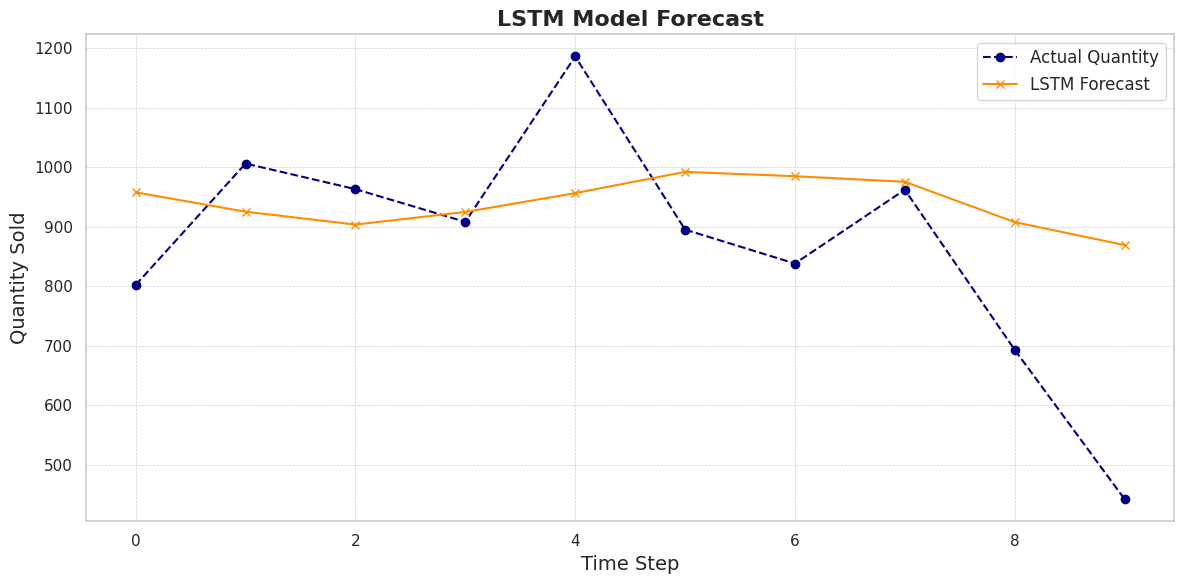

In [15]:
# Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual Quantity', marker='o', linestyle='--', color='navy')
plt.plot(predictions_inverse, label='LSTM Forecast', marker='x', linestyle='-', color='darkorange')
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)
plt.title('LSTM Model Forecast', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Xgboost Model

In [33]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 1. Data Preparation
xgboost_df = df.groupby("week_number").agg({
    'quantity': 'sum',
    'holiday': 'any'
}).reset_index()
xgboost_df['holiday'] = xgboost_df['holiday'].astype(int)

# Train-Test Split (80/20)
train_size = int(len(xgboost_df) * 0.8)
train, test = xgboost_df.iloc[:train_size], xgboost_df.iloc[train_size:]

# Prepare training and testing data (features and target)
X_train = train.drop(columns=['quantity'])
y_train = train['quantity']
X_test = test.drop(columns=['quantity'])
y_test = test['quantity']

Train The Xgboost Model

In [34]:
# Convert data to DMatrix (optimized data structure for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define a custom MAPE evaluation function for XGBoost
def mape1(y_pred, dtrain):
    y_true = dtrain.get_label()
    nonzero_mask = y_true != 0          # Avoid division by zero by considering only non-zero true values
    if np.sum(nonzero_mask) == 0:
        return 'mape', np.inf  # Alternatively, return 0 if preferred
    mape_value = round(np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100, 2)
    return 'mape', mape_value

# Define model parameters
params = {
    'objective': 'reg:squarederror',  # Regression with squared error loss
    'eval_metric': 'rmse',             # RMSE evaluation metric
    'learning_rate': 0.01,
    'max_depth': 5,
    'seed': 42
}

# Train the XGBoost model with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtest, 'eval')],
    feval=mape1,
    early_stopping_rounds=10
)

[0]	eval-rmse:198.37472	eval-mape:21.15000
[1]	eval-rmse:198.49548	eval-mape:21.16000
[2]	eval-rmse:198.61568	eval-mape:21.18000
[3]	eval-rmse:198.73531	eval-mape:21.19000
[4]	eval-rmse:198.85439	eval-mape:21.21000
[5]	eval-rmse:198.97289	eval-mape:21.22000
[6]	eval-rmse:199.09084	eval-mape:21.24000
[7]	eval-rmse:199.20820	eval-mape:21.25000
[8]	eval-rmse:199.32499	eval-mape:21.26000
[9]	eval-rmse:199.44123	eval-mape:21.28000


In [36]:
# Evaluate performance
train_predictions = model.predict(dtrain)  # Get predictions for the training set
train_mape = mape1(train_predictions, dtrain) # Calculate MAPE
mape = round(float(train_mape[1]),2)
print(f"Mean Absolute Percentage Error (MAPE): {train_mape[1]:.2f}%")  # Print MAPE
mape_scores["Xgboost"] = round(float(train_mape[1]),2)

Mean Absolute Percentage Error (MAPE): 6.17%


# Final Result & Evaluation

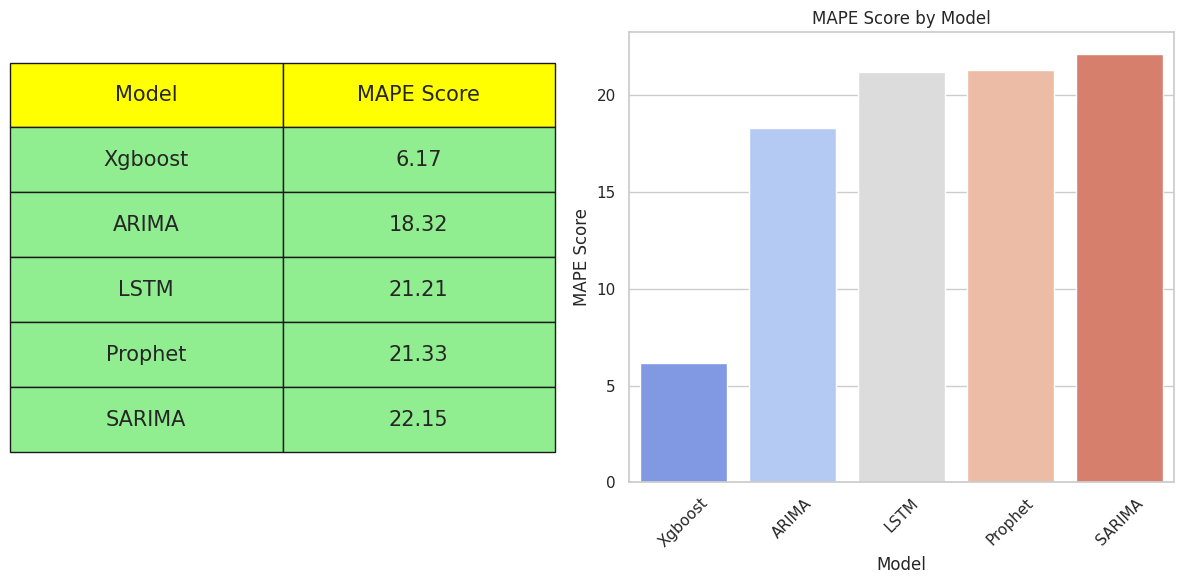

In [22]:
mape_scores = pd.DataFrame(mape_scores.items(), columns=['Model', 'MAPE Score'])
mape_scores = mape_scores.sort_values('MAPE Score', ascending=True)

# Creating a figure with 2 subplots (side by side)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].axis('off')  # Turn off the table's axis
header_color = ['yellow'] * len(mape_scores.columns)  # Header row color
row_colors = [['lightgreen'] * len(mape_scores.columns) for _ in range(len(mape_scores))]  # Body row colors
# Create table
table = axes[0].table(
    cellText=[mape_scores.columns.tolist()] + mape_scores.values.tolist(),  # Add headers to data
    cellLoc='center',
    loc='center',
    cellColours=[header_color] + row_colors  # Ensure same row count as table
)
table.set_fontsize(15)
table.scale(1, 4)   # Scale up the table for better visibility

# Bar Chart
sns.barplot(x='Model', y='MAPE Score', data=mape_scores, ax=axes[1], palette='coolwarm')
axes[1].set_title('MAPE Score by Model')
axes[1].set_ylabel('MAPE Score')
axes[1].set_xlabel('Model')
axes[1].tick_params(axis='x', rotation=45)

# Adjust spacing so elements don’t overlap
plt.tight_layout()
plt.show()

# Predict Next Week Sales

**Create separate dataframes for each pizza_name_id**

In [37]:
dfs_by_pizza = {}
for pizza_id in df['pizza_name_id'].unique():
    pizza_df = df[df['pizza_name_id'] == pizza_id].copy()
    # Sort by week number to maintain chronological order
    pizza_df.sort_values(by='week_number', inplace=True)
    dfs_by_pizza[pizza_id] = pizza_df

**Xgboost Model Building for each pizza**

In [38]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Dictionary to store next week predictions for each pizza
next_week_predictions = {}
# Loop through each pizza DataFrame in the dictionary
for pizza_id, pizza_df in dfs_by_pizza.items():
    # Work on a copy of the DataFrame so that the original is not modified
    data = pizza_df.copy()

    # Ensure the DataFrame is sorted (by week_number or date)
    data.sort_values(by='week_number', inplace=True)

    # Convert boolean holiday column to integer (if not already numeric)
    if data['holiday'].dtype == bool:
        data['holiday'] = data['holiday'].astype(int)

    # Define features (X) and target (y)
    # Here we use week_number and holiday as predictors of quantity.
    X = data[['week_number', 'holiday']]
    y = data['quantity']

    # Create an XGBoost DMatrix for the training data
    dtrain = xgb.DMatrix(X, label=y)

    # Define model parameters (tweak these parameters as needed for your data)
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': 0.1,
        'max_depth': 5,
        'seed': 42
    }

    # Train the XGBoost model on the entire historical data for this pizza
    num_boost_round = 50
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round)

    # To predict next week's sales:
    #   - Assume the next week's number is one greater than the maximum in current data.
    #   - For holiday, you might set it manually (here we assume 0 for non-holiday; adjust as needed).
    next_week_number = data['week_number'].max() + 1
    next_holiday = 0  # Assuming next week is not a holiday; modify if you have this information

    # Create a new DataFrame with the same feature columns for prediction
    new_data = pd.DataFrame({
        'week_number': [next_week_number],
        'holiday': [next_holiday]
    })
    dnew = xgb.DMatrix(new_data)

    # Predict the next week’s sales
    predicted_sales = model.predict(dnew)[0]

    # Store the prediction in the dictionary, keyed by pizza_name_id
    next_week_predictions[pizza_id] = predicted_sales

In [39]:
# Display the predictions for next week for each pizza
print("Next Week Sales Predictions:")
for pizza_id, prediction in next_week_predictions.items():
    print(f"{pizza_id}: {prediction:.2f}")

Next Week Sales Predictions:
bbq_ckn_l: 8.16
bbq_ckn_m: 12.31
bbq_ckn_s: 3.96
big_meat_s: 19.90
brie_carre_s: 4.86
calabrese_l: 4.29
calabrese_m: 3.04
calabrese_s: 1.24
cali_ckn_l: 9.57
cali_ckn_m: 8.95
cali_ckn_s: 9.14
ckn_alfredo_l: 1.54
ckn_alfredo_m: 8.14
ckn_alfredo_s: 2.92
ckn_pesto_l: 1.83
ckn_pesto_m: 5.06
ckn_pesto_s: 2.67
classic_dlx_l: 6.70
classic_dlx_m: 13.42
classic_dlx_s: 9.03
five_cheese_l: 12.44
four_cheese_l: 18.46
four_cheese_m: 4.83
green_garden_l: 3.65
green_garden_m: 2.54
green_garden_s: 6.76
hawaiian_l: 7.30
hawaiian_m: 3.93
hawaiian_s: 12.22
ital_cpcllo_l: 4.15
ital_cpcllo_m: 10.46
ital_cpcllo_s: 5.01
ital_supr_l: 7.42
ital_supr_m: 8.69
ital_supr_s: 1.52
ital_veggie_l: 2.54
ital_veggie_m: 4.48
ital_veggie_s: 2.59
mediterraneo_l: 1.83
mediterraneo_m: 4.39
mediterraneo_s: 2.77
mexicana_l: 7.98
mexicana_m: 4.55
mexicana_s: 3.18
napolitana_l: 7.00
napolitana_m: 2.68
napolitana_s: 7.16
pep_msh_pep_l: 5.28
pep_msh_pep_m: 4.79
pep_msh_pep_s: 2.98
pepperoni_l: 8.21
pepp

#  Purchase Order Creation

In [43]:
ingredients = pd.read_csv('/content/processed_ingredients.csv')
ingredients.drop(columns=['Unnamed: 0'], inplace=True)
ingredients.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [50]:
all_requirements = []

# Loop over each pizza in the predictions
for pizza_id, predicted_sales in next_week_predictions.items():
    # Filter ingredients data for the specific pizza
    subset = ingredients[ingredients['pizza_name_id'] == pizza_id].copy()

    # You can store the predicted quantity as well
    subset['Predicted_Quantity'] = round(predicted_sales)

    # Calculate total grams needed for each ingredient
    subset['Total_Grams_Needed'] = round(subset['Items_Qty_In_Grams'] * predicted_sales, 2)

    # Append to a list
    all_requirements.append(subset)

# Combine requirements for all pizzas into one DataFrame
requirements_df = pd.concat(all_requirements, ignore_index=True)

requirements_df.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,Predicted_Quantity,Total_Grams_Needed
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,8,326.39
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,8,122.40
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,8,163.20
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,8,244.80
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,8,489.59
